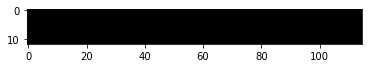

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor(102.)
tensor(0.1130)


In [61]:
import igraph
import torch
import matplotlib.pyplot as plt

#Database and Content Matrix
'''
A: Adjacency Matrix
D: Degree Matrix
L: Laplacien Matrix
B: Modularity Matrix
'''

#Import Dataset and calculate some constant matrix
#This data pre-process is used for graph data.
#If you want to 
Dataset = igraph.Graph.Read_GML("football.gml")
A = torch.Tensor(list(Dataset.get_adjacency()))
(node_number,node_number) = A.size()
D = torch.zeros(node_number,node_number)
for x in range(node_number):
    D[x,x] = A[x,:].sum()
e = D.trace()/2
L = D-A        #Graph laplacien matrix
B = torch.zeros(node_number,node_number)
for column in range(node_number):
    for row in range(node_number):
        B[row,column] = A[row,column] - D[row,row]*D[column,column]/(2*e)
        
#DNMF Algorithm
#A  = W1W2...WlHl
#hidden_layer equals l
#feature_number is the row of feature matrix H
def DNMF(input_matrix,hidden_layer,feature_number,epoch=50):
    (row,column) = input_matrix.size()
    A = input_matrix
    #Random init
    H = abs(torch.randn(feature_number,column))
    stride = int((row-feature_number)/hidden_layer)
    U_list = []
    for x in range(hidden_layer):
        U_list.append(abs(torch.randn(row-stride*x,row-stride*(x+1))))
        #print(U_list[x].size())
        if (x == (hidden_layer-1)): 
            U_list[x] = abs(torch.randn(row-stride*(hidden_layer-1),feature_number))
            
    #Optimization
    for counter in range(epoch):
        
        #Update W
        psi_list = list()
        phi_list = list()
        psi_list.append(torch.eye(row))
        phi_list.append(torch.eye(feature_number))
        for x in range(hidden_layer):
            psi_list.append(torch.mm(psi_list[-1],U_list[x]))
            phi_list.append(torch.mm(phi_list[-1].t(),U_list[hidden_layer-1-x].t()).t())
        for x in range(hidden_layer):
            psi = psi_list[x]
            phi = phi_list[hidden_layer-1-x]
            U = U_list[x]
            U_update_para_nume = torch.mm(torch.mm(torch.mm(psi.t(),A),H.t()),phi.t())
            U_update_para_deno = torch.mm(torch.mm(torch.mm(torch.mm(torch.mm(torch.mm(psi.t(),psi),U),phi),H),H.t()),phi.t())+1e-10
            U_list[x] = U_list[x] * (U_update_para_nume/U_update_para_deno)
                
        #Update H: ||A - WH||2 just like NMF
        U = torch.eye(row)
        for x in range(hidden_layer):
              U = torch.mm(U,U_list[x])
        H = H *torch.mm(U.t(),A)/(torch.mm(torch.mm(U.t(),U),H)+1e-10)
    
    return U_list,H

#--main program--
(U_list,H) = DNMF(A,hidden_layer=4,feature_number=12,epoch=100)
plt.imshow(H.squeeze(), cmap="gray")
plt.show()
print(H)

#Accuracy Analysis
community_number=12
result = []
for x in range(community_number):
    result.append(list())
for column in range(H.size()[1]):
    index = 0
    for row in range(H.size()[0]):
        if H[row,column]>H[index,column]:index = row
    result[index].append(column)
error_sample = 0
total_sample = A.size()[0]
for x in range(community_number):
    current_community = result[x]
    backet = torch.zeros(community_number)
    max = 0
    for member in current_community:
        backet[int(Dataset.vs["value"][member])] += 1
        if backet[int(Dataset.vs["value"][member])] > max : max = backet[int(Dataset.vs["value"][member])]
    error_sample += backet.sum() - max
print(error_sample)
accuracy = 1 - error_sample/total_sample
print(accuracy)
#DEBUG NOTE:
# 1.remember to make all element positive when initializing(2021.12.14)
# 2.